<a href="https://colab.research.google.com/github/bislara/Blood-Cell-Classification/blob/master/Blood_Cell_Classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os
import time


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.ImageFolder(root = "/content/drive/My Drive/Blood_cells_dataset/TRAIN", transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)

testset = torchvision.datasets.ImageFolder(root = "/content/drive/My Drive/Blood_cells_dataset/TEST", transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=4)


In [0]:
root_path = '/content/drive/My Drive/Blood_cells_dataset/TRAIN'
file_names = []
dir_names = []
root_names = []
for (root,dirs,files) in os.walk(root_path, topdown=True):
    file_names.append(files)
    dir_names.append(dirs)
    root_names.append(root)

classes = tuple(dir_names[0])


In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

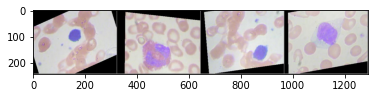

NEUTROPHIL LYMPHOCYTE NEUTROPHIL MONOCYTE
Input Size is  torch.Size([4, 3, 240, 320])


In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
print("Input Size is ",images.size())

In [0]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, in_fea = 3, out_fea = len(classes)):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_fea, 6, 5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 230 * 310, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_fea)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        #print("X size is: ",x.size())
        x = x.view(-1, 16 * 230 * 310)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [0]:
#check if cuda available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

step = 0
loss_train = []
loss_val = []

#import the model
net = Net()
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  net = nn.DataParallel(net)
net = net.to(device)


In [0]:
print(device)

cuda:0


In [0]:
net = net.train()
min_loss = 100
patience = 10
training_loss_store = []
validation_loss_store = []

import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter


In [0]:
writer = SummaryWriter('runs4_maxpool')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
file = open('logs_test4_epoch100_with_max_pool.txt', 'w')


In [0]:
print('training started.............................................')
file.write('training started.............................................\n')
start_time = time.time()
for epoch in range(20):  # loop over the dataset multiple times
    file.write('##############################TRAINING###############################\n')
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        step+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        #print("Input Size is ",inputs.size())
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss_train.append(loss.item())
        training_loss_store.append([epoch, loss.item()])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 10))
            #log_loss_summary(logger, loss_train, step, prefix = 'train_')
            file.write('epoch = '+ str(epoch + 1) + '\t' +'step = '+ str(step) +'\t'+'train_loss = '+'\t'+str(np.mean(loss_train)) +'\n')
            writer.add_scalar('Loss/train', np.mean(loss_train), step)
            loss_train = []
            running_loss = 0.0
            
    print('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time))
    file.write('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time) + '\n')
    file.write('##################################evaluation##############################\n')
    print('################################evaluation###########################\n')
    with torch.no_grad():
        val_loss = 0
        net.eval()
        
        for i, data in enumerate(testloader, 0):
            step+=1
            inputs, labels = data[0].to(device),data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_val.append(loss.item())
            validation_loss_store.append([epoch, loss.item()])
            val_loss += loss
            
        val_loss = val_loss/float(i + 1)
        
        if val_loss < min_loss:
            min_loss = val_loss
            no_impr_epoch = 0
            
            #save the best model
            torch.save(net.state_dict(), 'training/epoch_' + str(epoch+1) + 'loss_' + str(val_loss) + '.pt')
            
            print('performance improved with validation loss ' + str(val_loss))
            file.write('--------------------------------------------------------------------\n')
            file.write('performance improved with validation loss =  ' + str(val_loss) + '\n')
            
            file.write('epoch = '+ str(epoch + 1) + '\t' +'step = '+ str(step) +'\t'+'val_loss = '+'\t'+str(np.mean(loss_val)) +'\n')
            file.write('--------------------------------------------------------------------\n\n')
            #log_loss_summary(logger, loss_val, step, prefix="val_")
            writer.add_scalar('Loss/val',val_loss, step)
            loss_val = []
        else:
            no_impr_epoch += 1
            print('no improvement with prev best model ' + str(no_impr_epoch) + 'th')
            file.write('no improvement with prev best model ' + str(no_impr_epoch) + 'th \n')
            
        if no_impr_epoch > patience:
            print('stop training')
            file.write('stop training')
            break
    writer.add_scalar('Memory Allocation', torch.cuda.memory_allocated(), step)
    
print('Finished Training................................................')
file.write('Finished Training................................................\n')
end_time = time.time()
file.write('Training time:- ' + str(end_time - start_time))
file.close()


training started.............................................
[1,    10] loss: 1.387
[1,    20] loss: 1.402
[1,    30] loss: 1.383
[1,    40] loss: 1.405
[1,    50] loss: 1.406
[1,    60] loss: 1.391
[1,    70] loss: 1.387
[1,    80] loss: 1.385
[1,    90] loss: 1.383
[1,   100] loss: 1.394
[1,   110] loss: 1.389
[1,   120] loss: 1.387
[1,   130] loss: 1.381
[1,   140] loss: 1.391
[1,   150] loss: 1.390
[1,   160] loss: 1.390
[1,   170] loss: 1.387
[1,   180] loss: 1.384
[1,   190] loss: 1.381
[1,   200] loss: 1.399
[1,   210] loss: 1.387
[1,   220] loss: 1.390
[1,   230] loss: 1.389
[1,   240] loss: 1.389
[1,   250] loss: 1.387
[1,   260] loss: 1.391
[1,   270] loss: 1.392
[1,   280] loss: 1.390
[1,   290] loss: 1.390
[1,   300] loss: 1.391
[1,   310] loss: 1.389
[1,   320] loss: 1.388
[1,   330] loss: 1.380
[1,   340] loss: 1.384
[1,   350] loss: 1.372
[1,   360] loss: 1.394
[1,   370] loss: 1.376
[1,   380] loss: 1.395
[1,   390] loss: 1.400
[1,   400] loss: 1.387
[1,   410] loss: 1

In [0]:
#Release all unoccupied cached memory in GPU
if(torch.cuda.is_available()):
    torch.cuda.empty_cache()


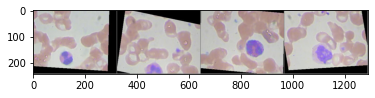

Ground Truth:  EOSINOPHIL LYMPHOCYTE LYMPHOCYTE MONOCYTE
Predicted:  LYMPHOCYTE LYMPHOCYTE LYMPHOCYTE EOSINOPHIL
LYMPHOCYTE :-  1.2980493
NEUTROPHIL :-  -0.3825528
MONOCYTE :-  -1.8159348
EOSINOPHIL :-  -0.029355615


In [0]:
PATH = "training/epoch_4loss_tensor(1.2321, device='cuda:0').pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
i = outputs.detach().numpy()
#print('Scores:-', i)
for j in range(len(classes)):
    print(classes[j], ':- ', i[0, j])

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0], data[1]
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


Accuracy of the network on the test images: 40 %


In [0]:
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0], data[1]
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for i in range(1):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

#file = open('result_logs.txt', 'w')
for i in range(4):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    #file.write('Accuracy of' + classes[i] + ':' + '\t' + str(100 * class_correct[i] / class_total[i]) +'%'+'\n')
    writer.add_scalar('Class_accuracy', 100 * (class_correct[i] / class_total[i]), i)


Accuracy of LYMPHOCYTE : 32 %
Accuracy of NEUTROPHIL : 64 %
Accuracy of MONOCYTE : 12 %
Accuracy of EOSINOPHIL : 54 %


In [0]:
file.close()
writer.close()

In [0]:
torch.save(net.state_dict(), 'model.pt')